In [37]:
from src import incremental_transformer as it
from src import shift_comparison_predictor as shift_pred
from src import simple_comparison_predictor as simple_pred
import pandas as pd
from src import normalization as norm
import numpy as np
%matplotlib inline

In [38]:
import matplotlib.pylab as plt
# plt.rcParams['figure.figsize'] = 12, 9
plt.rcParams['figure.figsize'] = 9, 6
plt.rcParams['figure.figsize'] = 7, 5

In [3]:
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Arial'

In [4]:
mpl.rcParams['font.sans-serif'].insert(0, 'Liberation Sans')
mpl.rcParams['font.sans-serif'].insert(0, 'Arial')
mpl.rcParams['font.family'] = 'sans-serif'

In [5]:
import seaborn as sns
sns.axes_style()

{'axes.axisbelow': True,
 'axes.edgecolor': 'white',
 'axes.facecolor': '#EAEAF2',
 'axes.grid': True,
 'axes.labelcolor': '.15',
 'axes.linewidth': 0,
 'figure.facecolor': 'white',
 'font.family': 'sans-serif',
 'font.sans-serif': ['Arial',
  'Liberation Sans',
  'Bitstream Vera Sans',
  'sans-serif'],
 'grid.color': 'white',
 'grid.linestyle': '-',
 'image.cmap': 'Greys',
 'legend.frameon': False,
 'legend.numpoints': 1,
 'legend.scatterpoints': 1,
 'lines.solid_capstyle': 'round',
 'text.color': '.15',
 'xtick.color': '.15',
 'xtick.direction': 'out',
 'xtick.major.size': 0,
 'xtick.minor.size': 0,
 'ytick.color': '.15',
 'ytick.direction': 'out',
 'ytick.major.size': 0,
 'ytick.minor.size': 0}

In [39]:
def rmse(prediction, target):
    return np.sqrt(((prediction - target) ** 2).mean())

In [3]:
def mape(prediction, target):
    return np.mean(np.abs((target - prediction) / target)) * 100

In [4]:
def smape(prediction, target):
    return np.mean(np.abs(target - prediction) / np.abs(target + prediction)) * 200

In [5]:
def mae(prediction, target):
    return np.mean(np.abs(target - prediction)) * 100

In [6]:
def mdae(prediction, target):
    return np.median(np.abs(target - prediction)) * 100

In [40]:
filename = "~/shared/energo_data/belgicko.csv"
data = pd.DataFrame.from_csv(filename, index_col=[0])

In [41]:
len(data)

374496

In [42]:
data.head(5)

,value
date,
2005-01-01 00:15:00,9503607
2005-01-01 00:30:00,9357379
2005-01-01 00:45:00,9181671
2005-01-01 01:00:00,9067683
2005-01-01 01:15:00,9007000


In [43]:
sample_data = data[0:(96*14)]

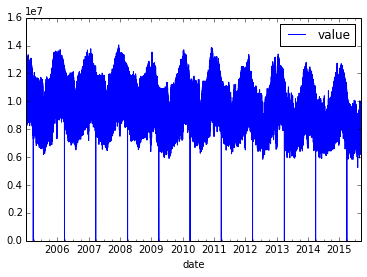

In [10]:
data.plot()

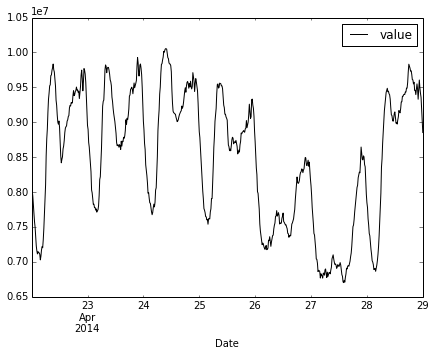

In [48]:
start = 96*3398
subsample = data[start:(start+96*7)]
ax = subsample.plot(color='black')
ax.set_xlabel('Date')

# Len taky pokus a definicia funkcii na pracu s PAA

In [49]:
def paa(series, coefficient):
    """
    series - data na transformaciu
    coefficient - pocet za sebou nasledujucich hodnot, ktore sa maju spojit    
    """
    sub_series = series[0:((len(series) / coefficient) * coefficient)] # skratenie na nasobok koeficientu
    composite_list = [sub_series[x:x+coefficient] for x in range(0, len(sub_series),coefficient)] # rozsekanie na kusky dlzku koeficientu
    result = [x.mean() for x in composite_list]
    return sub_series, pd.Series(result) # vracia aj skratenu hodnotu a aj paa reprezentaciu

In [50]:
def un_paa(series, coefficient):
    """
    series - data na transformaciu
    coefficient - pocet za sebou nasledujucich hodnot, ktore sa maju vytvorit    
    """
    array = []
    for x in series:
        array += ([x] * coefficient)
    return pd.Series(array)

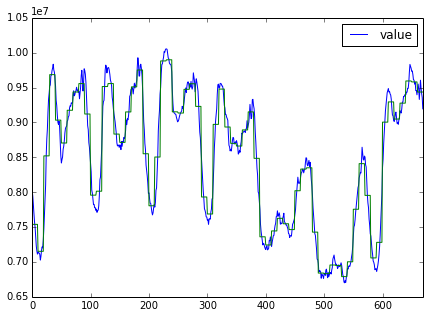

In [51]:
coefficient = 10
subseries, result = paa(subsample.value, coefficient)
reconstructed = un_paa(result, coefficient)
subseries.reset_index().plot()
reconstructed.plot()

In [15]:
rmse(np.array(reconstructed), np.array(subseries))

281526.59724356892

In [16]:
rmses = []
coefficients = []
sizes = []

for coefficient in xrange(2, 96):
    subseries, result = paa(sample_data.value, coefficient)
    reconstructed = un_paa(result, coefficient)
    rmses.append(rmse(np.array(reconstructed), np.array(subseries)))
    sizes.append(int(len(sample_data) / coefficient))
    coefficients.append(coefficient)

In [17]:
paa_results2 = pd.DataFrame()
paa_results2['Transformed data size'] = sizes
# paa_results['coefficient'] = coefficients
paa_results2['RMSE'] = rmses
paa_results2.index = coefficients

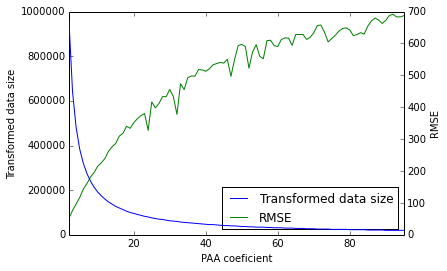

In [18]:
ax = paa_results2.plot(secondary_y=['Transformed data size'], mark_right=False)
ax.set_ylabel('Transformed data size')
ax.set_xlabel('PAA coeficient')
ax.right_ax.set_ylabel('RMSE')

# Pokusy a definicia funkcii na pracu s mojou reprezentaciou

In [52]:
normalization = norm.ZNormalization()
# Natrenovanie koeficientov normalizacie na prvom tyzdni dat
normalization.train_coefficients(data.value[0:(96*7)])

In [53]:
trans = it.IncrementalTransformer(96, 96, 2.0, normalization=normalization)
symbols = trans.transform(subsample.value)

In [54]:
result = trans.reconstruct(symbols)

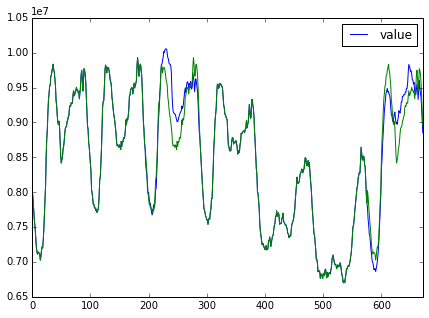

In [55]:
subsample.reset_index().plot()
pd.Series(result).plot()

# zavyslost od mnozstva spracovanych dat

In [56]:
sample_data = data
# sample_data = data[0:(96*7*20)]

In [57]:
coefficient = 10

step = 96 * 7

isc_rmse = []
isc_size = []
paa_rmse = []
paa_size = []
data_sizes = []

normalization = norm.ZNormalization()
# Natrenovanie koeficientov normalizacie na prvom tyzdni dat
normalization.train_coefficients(data.value[0:(96*7)])

In [58]:
for data_size in xrange(1,int(len(sample_data)/step)):
    subsample = sample_data.value[0:(data_size * step)]
    data_sizes.append(data_size * step)
    
    trans = it.IncrementalTransformer(96, 96, 2.3, normalization=normalization)
    symbols = trans.transform(subsample)
    isc_result = trans.reconstruct(symbols)
    
    isc_rmse.append(rmse(isc_result, subsample[0:(len(isc_result))]))
    isc_size.append((len(symbols) * 3) + (trans.distance_matrix.size() * 96))
    
    paa_subseries, paa_result = paa(subsample, coefficient)
    paa_reconstructed = un_paa(paa_result, coefficient)
    paa_rmse.append(rmse(np.array(paa_reconstructed), np.array(paa_subseries)))
    paa_size.append(int(len(subsample) / coefficient))

In [59]:
all_results = pd.DataFrame()
all_results['PAA data size'] = paa_size
all_results['PAA RMSE'] = paa_rmse
all_results['ISC data size'] = isc_size
all_results['ISC RMSE'] = isc_rmse
all_results['Amount of processed data'] = data_sizes

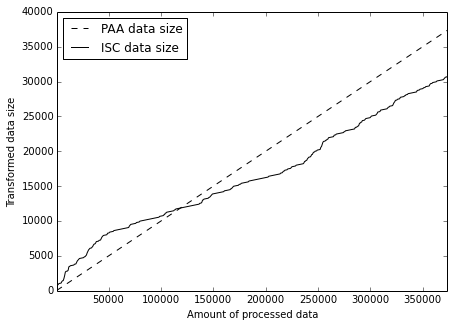

In [60]:
ax = all_results.plot(x='Amount of processed data', y=['PAA data size', 'ISC data size'], style=['--','-'], color=['black', 'black'])
ax.set_ylabel('Transformed data size')
ax.set_xlabel('Amount of processed data')

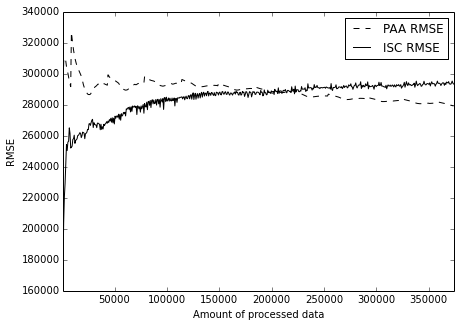

In [61]:
ax = all_results.plot(x='Amount of processed data', y=['PAA RMSE', 'ISC RMSE'], style=['--','-'], color=['black', 'black'])
ax.set_ylabel('RMSE')
ax.set_xlabel('Amount of processed data')

In [25]:
prepocitat znova a nezabudnut zmazal stare data. Nova hodnota podobnosti by mala byt 2.3

SyntaxError: invalid syntax (<ipython-input-25-c1d0fe1869ac>, line 1)

ta rastuca chyba sa da pripisat deterioration of alphabet, co implikuje moje dalsie kroky. Do clanku do casopisu to musim napisat. Mozem sa tak pekne presunut k tomu, co treba robit dalej.

motivacia: mozem povedat, ze teraz je velky topic paralelna analyza metrik nad prichadzajucim prudom dat, pre ktoru potrebujem nejaku reprezentaciu. Bum. Musim ale spravit related work o paralelnej analyze prudov data a zaroven o metodach, ktore sa na to pouzivaju v oblasti casovych radov a aj v oblasti, kde to chcem symbolickou reprezentaciou posunut. Cize nieco o analyze vela dokumentov (suborov symbolov).

potrebujem si najst clanok, kde jasne pomenuju potrebu analyzovat paralelne metriky nad prudom dat, respektive pomenovat to, ze je problem analyzovat velky pocet paralelnych prudov dat

In [26]:
3*len(subsample)/96

11676

In [62]:
all_results2 = pd.DataFrame()
all_results2['PAA data size'] = paa_size
all_results2['ISC symbol size'] = 3 * all_results['Amount of processed data'] / 96
all_results2['ISC alphabet size'] = all_results['ISC data size'] - (3 * all_results['Amount of processed data'] / 96)
all_results2['ISC data size'] = isc_size
all_results2['Amount of processed data'] = all_results['Amount of processed data']

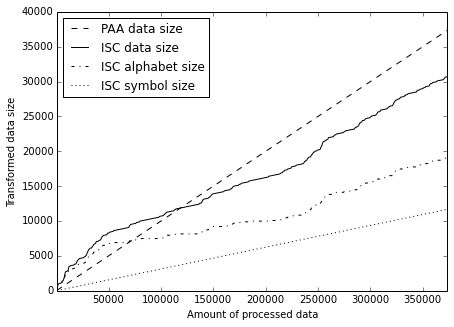

In [63]:
ax = all_results2.plot(x='Amount of processed data', y=['PAA data size', 'ISC data size', 'ISC alphabet size', 'ISC symbol size'],
                      style=['--', '-', '-.',':'], color=['black','black','black','black'])
ax.set_ylabel('Transformed data size')
ax.set_xlabel('Amount of processed data')

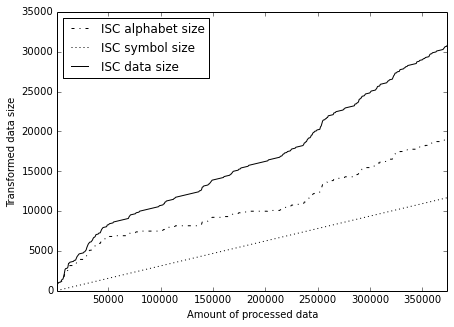

In [64]:
ax = all_results2.plot(x='Amount of processed data', y=['ISC alphabet size', 'ISC symbol size', 'ISC data size'], style=['-.',':','-'], color=['black', 'black', 'black'])
ax.set_ylabel('Transformed data size')
ax.set_xlabel('Amount of processed data')